In [1]:
import zipfile
import os
import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import boto3
import pandas as pd
from io import BytesIO
from io import StringIO
import json
import requests 

In [2]:
# Initialize S3 client
s3 = boto3.client('s3')

# Function to load data 
bucket_name = 'ml-stack-759578648427-us-west-2'

def from_s3(bucket_name, file_name):
    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    ext = os.path.splitext(file_name)[1]
    if ext == '.gz':
        data = pd.read_csv(BytesIO(response['Body'].read()), compression='gzip')
    elif ext == '.csv':
        data = pd.read_csv(BytesIO(response['Body'].read()))
    else:
        data = pd.read_excel(BytesIO(response['Body'].read()), sheet_name='DX_to_CCSR_Mapping', header=1)
    return data

# Import Modeling Set

In [3]:
file_name = 'MIMIC/final_subject_charttime_df.csv.gz'
df = from_s3(bucket_name, file_name) 
df['charttime'] = pd.to_datetime(df['charttime'])
subjects = df['subject_id'].unique()
df.head()

,subject_id,charttime
0,10000826,2146-12-08 22:22:00
1,10000898,2187-09-26 08:00:00
2,10000980,2185-10-24 00:00:00
3,10001122,2142-04-08 10:48:00
4,10001401,2134-10-09 13:45:00


# Pharmacy

In [63]:
file_name = 'MIMIC/pharmacy.csv.gz'
pharm = from_s3(bucket_name, file_name) 
# filter subjects 
pharm = pharm[pharm['subject_id'].isin(subjects)]
pharm = pharm[['subject_id', 'medication', 'entertime']].drop_duplicates().dropna()
pharm.head()

/tmp/ipykernel_260/1980421374.py:11: DtypeWarning: Columns (16,18,24,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(BytesIO(response['Body'].read()), compression='gzip')


In [134]:
antibiotics = ['AMPICILLIN', 'AMPICILLIN/SULBACTAM', 'CEFAZOLIN', 'CEFEPIME', 'CEFTAZIDIME', 'CEFTRIAXONE', 'CIPROFLOXACIN', 'GENTAMICIN', 'MEROPENEM', 
               'NITROFURANTOIN', 'PIPERACILLIN', 'TOBRAMYCIN', 'TRIMETHOPRIM']
pharm_anti = pharm[pharm.medication.str.contains('|'.join(antibiotics), case=False)]

In [135]:
# merge to df 
df_pharm = df.merge(pharm_anti, on='subject_id', how='left')
df_pharm['entertime'] = pd.to_datetime(df_pharm['entertime'])
df_pharm['hours_to_prescribe'] = (df_pharm.entertime - df_pharm.charttime).dt.total_seconds() / 3600
df_pharm = df_pharm[(df_pharm.hours_to_prescribe > 0) & (df_pharm.hours_to_prescribe <= 72)]
df_pharm.drop(columns=['entertime'], inplace=True)
df_pharm = df_pharm.loc[df_pharm.groupby(['subject_id', 'charttime', 'medication'])['hours_to_prescribe'].idxmin()]
df_pharm.head()

,subject_id,charttime,medication,hours_to_prescribe
1,10000826,2146-12-08 22:22:00,Ciprofloxacin HCl,11.162
10,10001401,2134-10-09 13:45:00,CefePIME,3.164
104,10002013,2165-11-23 06:38:00,CefePIME,13.546
127,10002114,2162-02-17 21:53:00,CefTRIAXone,2.187
129,10002131,2128-03-17 00:00:00,CeftriaXONE,34.376


In [138]:
#sorted(list(df_pharm.medication.unique()))
ab_map = {
	'Ampicillin':'AMPICILLIN',
	 'Ampicillin Desensitization':'AMPICILLIN',
	 'Ampicillin Graded Challenge':'AMPICILLIN',
	 'Ampicillin-Heparin Lock':'AMPICILLIN',
	 'Ampicillin-Sulbact Graded Challenge':'AMPICILLIN/SULBACTAM',
	 'Ampicillin-Sulbactam':'AMPICILLIN/SULBACTAM',
	 'CeFAZolin':'CEFAZOLIN',
	 'CeFAZolin Desensitization':'CEFAZOLIN',
	 'CeFAZolin Graded Challenge':'CEFAZOLIN',
	 'CefTAZidime':'CEFTAZIDIME', 
	 'CefTAZidime 2mg/0.1mL':'CEFTAZIDIME', 
	 'CefTAZidime Graded Challenge':'CEFTAZIDIME', 
	 'CefTAZidime-Avibactam (Avycaz)':'CEFTAZIDIME', 
	 'CefTAZidime-Heparin Lock':'CEFTAZIDIME', 
	 'CefTRIAXone':'CEFTRIAXONE',
	 'CefTRIAXone Graded Challenge':'CEFTRIAXONE',
	 'CefazoLIN':'CEFAZOLIN',
	 'CefePIME':'CEFEPIME', 
	 'Cefepime Desensitization':'CEFEPIME', 
	 'Cefepime Graded Challenge':'CEFEPIME', 
	 'CeftazIDIME':'CEFTAZIDIME', 
	 'CeftriaXONE':'CEFTRIAXONE',
	 'CeftriaXONE Desensitization':'CEFTRIAXONE',
	 'Ciprofloxacin':'CIPROFLOXACIN',
	 'Ciprofloxacin 0.3% Ophth Soln':'CIPROFLOXACIN',
	 'Ciprofloxacin HCl':'CIPROFLOXACIN',
	 'Gentamicin':'GENTAMICIN',
	 'Gentamicin (L&D/OB)':'GENTAMICIN',
	 'Gentamicin - Dosing by pharmacy':'GENTAMICIN',
	 'Gentamicin 0.1% Cream':'GENTAMICIN',
	 'Gentamicin 0.3% Ophth. Ointment':'GENTAMICIN',
	 'Gentamicin 0.3% Ophth. Soln':'GENTAMICIN',
	 'Gentamicin 2.5 mg/mL in Sodium Citrate 4%':'GENTAMICIN',
	 'Gentamicin Intraperitoneal':'GENTAMICIN',
	 'Gentamicin Intraventricular':'GENTAMICIN',
	 'Gentamicin Sulf. Ophth. Soln':'GENTAMICIN',
	 'Gentamicin-Heparin Lock':'GENTAMICIN',
	 'MEROPENEM':'MEROPENEM', 
	 'Meropenem':'MEROPENEM', 
	 'Meropenem Desensitization':'MEROPENEM', 
	 'Meropenem Graded Challenge':'MEROPENEM', 
	 'Nitrofurantoin ':'NITROFURANTOIN',
	 'Nitrofurantoin (Macrodantin)':'NITROFURANTOIN',
	 'Nitrofurantoin Monohyd (MacroBID)':'NITROFURANTOIN',
	'Piperacillin-Tazo Graded Challenge':'PIPERACILLIN/TAZO',
	 'Piperacillin-Tazobactam':'PIPERACILLIN/TAZO',
	 'Piperacillin-Tazobactam Na':'PIPERACILLIN/TAZO',
	 'Piperacillin-Tazobactam-Heparin Lock':'PIPERACILLIN/TAZO',
	'Polymyxin B -Trimethoprim Ophth Soln':'TRIMETHOPRIM/SULFA',
     'Polytrim (trimethoprim + polymyxin B)':'TRIMETHOPRIM/SULFA',
     'Sulfameth/Trimethoprim':'TRIMETHOPRIM/SULFA',
     'Sulfameth/Trimethoprim ':'TRIMETHOPRIM/SULFA',
     'Sulfameth/Trimethoprim DS':'TRIMETHOPRIM/SULFA',
     'Sulfameth/Trimethoprim SS':'TRIMETHOPRIM/SULFA',
     'Sulfameth/Trimethoprim Suspension':'TRIMETHOPRIM/SULFA',
     'Sulfamethoxazole-Trimethoprim':'TRIMETHOPRIM/SULFA',
	 'Tobramycin':'TOBRAMYCIN',
	 'Tobramycin - Dosing by pharmacy':'TOBRAMYCIN',
	 'Tobramycin 0.3% Ophth Ointment':'TOBRAMYCIN',
	 'Tobramycin 0.3% Ophth Soln':'TOBRAMYCIN',
	 'Tobramycin 2.5 mg/mL in Sodium Citrate 4%':'TOBRAMYCIN',
	 'Tobramycin Fortified Ophth. Soln.':'TOBRAMYCIN',
	 'Tobramycin Inhalation Soln':'TOBRAMYCIN',
	 'Tobramycin-Dexamethasone Ophth Oint':'TOBRAMYCIN',
	 'Tobramycin-Dexamethasone Ophth Susp':'TOBRAMYCIN',
	 'cefTAZidime':'CEFTAZIDIME', 
	 'ceftazidime-avibactam':'CEFTAZIDIME', 
	 'tobramycin in 0.225 % NaCl':'TOBRAMYCIN'
	}
df_pharm['ab_name_pr'] = df_pharm.medication.map(ab_map)
df_pharm.head()

,subject_id,charttime,medication,hours_to_prescribe,ab_name_pr
1,10000826,2146-12-08 22:22:00,Ciprofloxacin HCl,11.162,CIPROFLOXACIN
10,10001401,2134-10-09 13:45:00,CefePIME,3.164,CEFEPIME
104,10002013,2165-11-23 06:38:00,CefePIME,13.546,CEFEPIME
127,10002114,2162-02-17 21:53:00,CefTRIAXone,2.187,CEFTRIAXONE
129,10002131,2128-03-17 00:00:00,CeftriaXONE,34.376,CEFTRIAXONE


<Axes: >

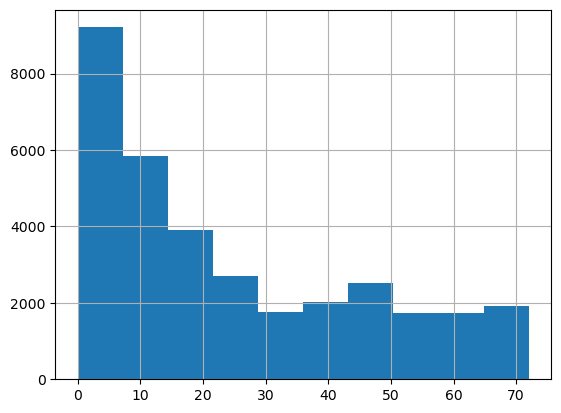

In [139]:
df_pharm.hours_to_prescribe.hist()

In [140]:
# average time to prescribe anitbiotic from chart time 
df_pharm.hours_to_prescribe.mean()

24.512189573341328

In [141]:
df_pharm.groupby('ab_name_pr')['hours_to_prescribe'].mean()

ab_name_pr
AMPICILLIN             36.405
AMPICILLIN/SULBACTAM   24.369
CEFAZOLIN              24.478
CEFEPIME               20.304
CEFTAZIDIME            27.670
CEFTRIAXONE            21.824
CIPROFLOXACIN          28.159
GENTAMICIN             25.275
MEROPENEM              29.774
NITROFURANTOIN         32.871
PIPERACILLIN/TAZO      17.690
TOBRAMYCIN             25.873
TRIMETHOPRIM/SULFA     30.118
Name: hours_to_prescribe, dtype: float64

In [142]:
# merge with df 
df_pharm_final = df.merge(df_pharm, on=['subject_id', 'charttime'], how='left')
df_pharm_final.ab_name_pr.fillna('OTHER', inplace=True)
df_pharm_final.head()

/tmp/ipykernel_260/198233475.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_pharm_final.ab_name_pr.fillna('OTHER', inplace=True)


,subject_id,charttime,medication,hours_to_prescribe,ab_name_pr
0,10000826,2146-12-08 22:22:00,Ciprofloxacin HCl,11.162,CIPROFLOXACIN
1,10000898,2187-09-26 08:00:00,NaN,NaN,OTHER
2,10000980,2185-10-24 00:00:00,NaN,NaN,OTHER
3,10001122,2142-04-08 10:48:00,NaN,NaN,OTHER
4,10001401,2134-10-09 13:45:00,CefePIME,3.164,CEFEPIME


In [143]:
s3_key = 'MIMIC/Cleaned/df_final_antibiotic_prescribed.csv'

# Save the DataFrame to a CSV in memory (using StringIO)
csv_buffer = StringIO()
df_pharm.to_csv(csv_buffer, index=False)

# Upload the CSV data to S3
s3.put_object(Bucket=bucket_name, Key=s3_key, Body=csv_buffer.getvalue())

print(f"DataFrame successfully exported to s3://{bucket_name}/{s3_key}")

DataFrame successfully exported to s3://ml-stack-759578648427-us-west-2/MIMIC/Cleaned/df_final_antibiotic_prescribed.csv
